# Clean Data

  ---

#### Author: Damian Pietroń 

---

## Import libraries

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import xlrd 
import datetime
import os

---

## Prepare data for cleaning

- Access the directory containing the CSV files.
- Store the paths of all CSV files in the `all_csv` variable, which is of type `list[string]`.
- Initialize the `data_frames` dictionary to hold the DataFrame for each patient's data.

`data_frames` structure: 

| Key        | Type   | Value          | Type              |
|------------|--------|----------------|-------------------|
| `file_name`| string | `patient_data` | `pd.DataFrame`    |

In [31]:
data_folder = Path("data") # Path to the data folder
all_csv = list(data_folder.glob("*.csv")) # List of all the csv files in the data folder

In [32]:
data_frames = {file.stem: pd.read_csv(file, sep=";", decimal=",") for file in tqdm(all_csv)}

100%|██████████| 5/5 [00:00<00:00, 72.92it/s]


---

## Manage date-time format

- Introduce a new column named `time`, with its data type set to `pd.DateTime`.
- Convert the `DateTime` column to the pandas `DateTime` data type for consistency.

In [33]:
def icmp_dateformat_to_datetime(icmp_time_mark):
    """
    Convert ICMP time mark to datetime format
    
    Args:
        icmp_time_mark (float): ICMP time mark
    
    Returns:
        datetime_date (datetime): Datetime format of ICMP time mark
    """
    datetime_date = xlrd.xldate_as_datetime(icmp_time_mark, 0)
    datetime_date = datetime_date + datetime.timedelta(hours=1)
    return datetime_date

In [34]:
def time_encoder(df):
  """
  Encode time features from datetime column
  
  Args:
      df (DataFrame): Dataframe to encode time features
      
  Returns:
      df (DataFrame): Dataframe with encoded time 
  """
  df['time'] = pd.to_datetime(df['DateTime'])
  return df

In [35]:
for patient in tqdm(data_frames): 
  df = data_frames[patient] # get the data of the patient
  df['DateTime'] = df['DateTime'].apply(icmp_dateformat_to_datetime) # convert icmp time mark to datetime
  df = time_encoder(df) # encode time features

100%|██████████| 5/5 [00:00<00:00, 31.89it/s]


---

## Cancel unused data

- Remove the `['TEMP', 'cpp', 'AMP']` columns due to their lack of variability or because they are predominantly NaNs.
- Eliminate any rows containing NaN values across the dataset.
- Visualize the `ABP` column data prior to the cleaning process.

  0%|          | 0/5 [00:00<?, ?it/s]

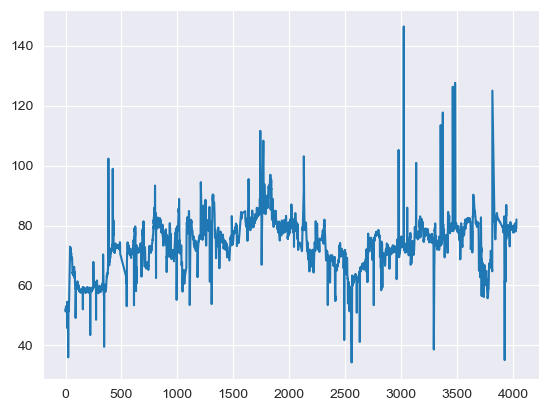

 20%|██        | 1/5 [00:00<00:01,  3.29it/s]

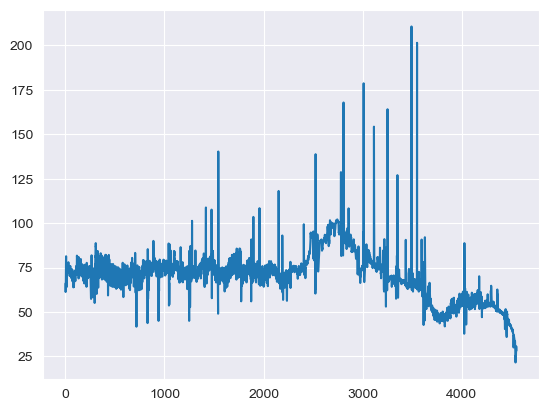

 40%|████      | 2/5 [00:00<00:00,  4.34it/s]

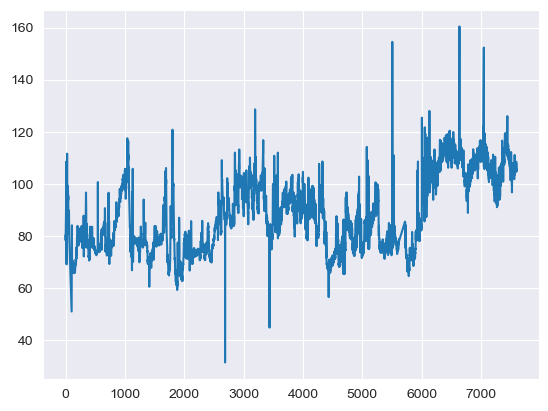

 60%|██████    | 3/5 [00:00<00:00,  4.72it/s]

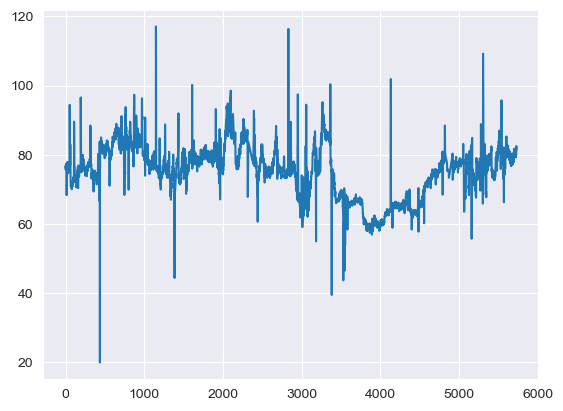

 80%|████████  | 4/5 [00:00<00:00,  5.48it/s]

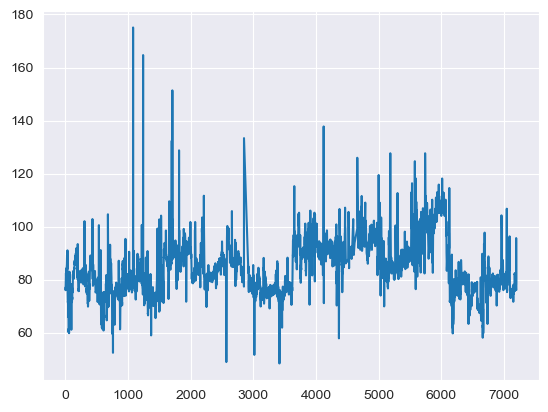

100%|██████████| 5/5 [00:00<00:00,  5.18it/s]


In [36]:
for key, df in tqdm(data_frames.items()):
    data_frames[key] = df.drop(columns=['TEMP', 'cpp', 'AMP'])
    data_frames[key] = data_frames[key].dropna()
    data_frames[key]["ABP"].plot()
    plt.show()

---

## Calculate differences between data and create slices 

- Calculate the time differences between consecutive data entries.
- Record these time differences in the `diff_sec` column.
- Identify segments where the time differences deviate from the expected sampling interval (**60 seconds**), and segment the data accordingly.
- Collect these segmented slices of data into the `patient_sliced_data` variable.
- Visualize all segmented slices together in a single matplotlib figure.

`patient_sliced_data` structure:
| Key        | Type   | Value          | Type              |List[Type] |
|------------|--------|----------------|-------------------|-----------|
| `file_name`| string |    `slices`    |       `list`      | `pd.DataFrame`|

In [37]:
def calculate_differences(data):
    """
    Calculate the differences between the timestamps in the data
    
    Args:
    data (pd.DataFrame): Dataframe containing the timestamps
    
    Returns:
    data (pd.DataFrame): Dataframe containing the timestamps and the differences between them
    
    """
    data['diff_sec'] = data['time'].diff().dropna()
    data['diff_sec'] = data['diff_sec'].apply(lambda x: x.total_seconds())
    return data

In [38]:
def slice_data_by_diff_in_sampling(data):
    """
    Slice data if there is difference in sampling 
    
    Args:
        data (pd.DataFrame): Data to be sliced
    
    Returns:
        sliced_data (pd.DataFrame): Sliced data
    """
    NORMAL_SAMPLING_VALUE_SECONDS = 60 
    data = calculate_differences(data)
    slices = []
    start_of_a_new_slice = 0
    for i in range(len(data)):
        if data['diff_sec'].iloc[i] != NORMAL_SAMPLING_VALUE_SECONDS:
          slices.append(data.iloc[start_of_a_new_slice:i])
          start_of_a_new_slice = i
    slices.append(data.iloc[start_of_a_new_slice:])    
    return slices

In [39]:
def analize_slices(slices):
  """
  Analize slices of data
  
  Args:
      slices (list): List of data slices
  
  Returns:
      None
  """
  for slice in slices:
    plt.plot(slice['ABP'])

In [40]:
patient_sliced_data = {}
for patient in data_frames.keys():
  sliced_data = slice_data_by_diff_in_sampling(data_frames[patient])
  patient_sliced_data[patient] = sliced_data

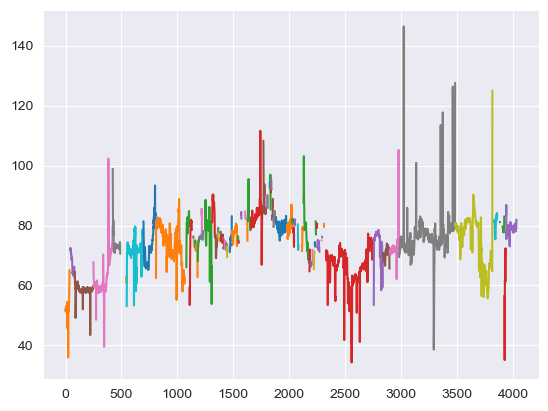

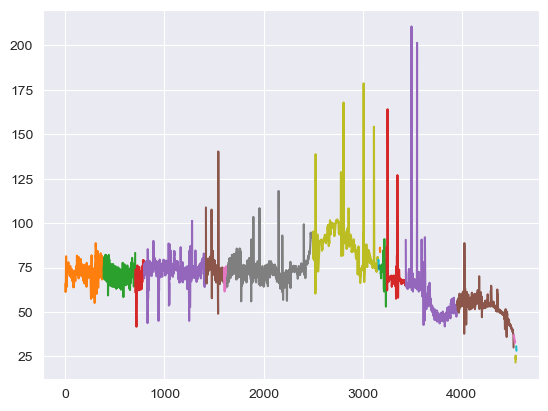

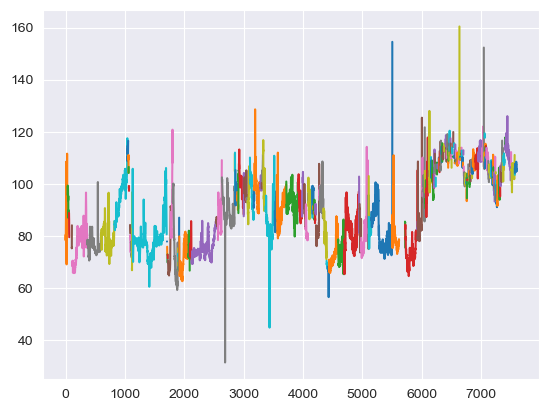

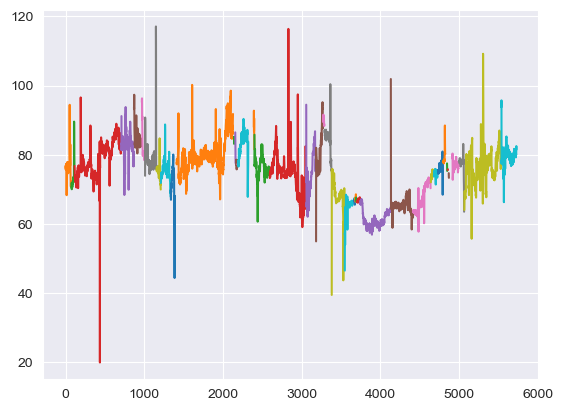

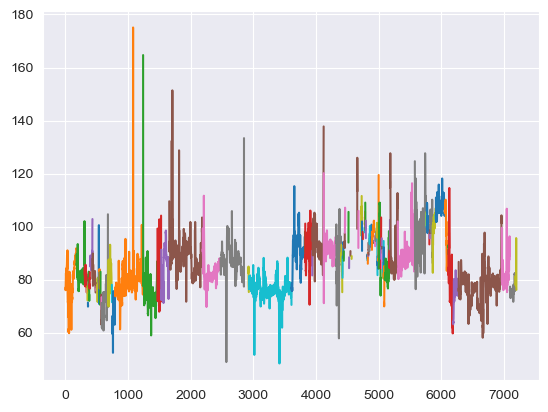

In [41]:
for patient in patient_sliced_data:
  analize_slices(patient_sliced_data[patient])
  plt.show()

---

## Based on local avg find outliers

- Filter data slices, discarding those with fewer than 10 entries as they are likely artifacts.
- Identify outliers using the Modified Interquartile Range (IQR) method.
- Accumulate identified outliers in the `all_outliers` variable.
- Visualize both the outliers and the original data in a plot.
- Consolidate all outliers into a single DataFrame for further analysis.

- The structure of the `all_outliers` variable is unique in this context. Below is the current structure of `all_outliers`:

| Key         | Type   | Value       | Type            |
|-------------|--------|-------------|-----------------|
| `file_name` | string | `outliers`  | `pd.DataFrame`  |

In [42]:
def find_outliers(data):
    """
    Find outliers in the data, following the IQR method
    
    Args:
        data (pd.DataFrame): Data to find outliers in
    
    Returns:
        outliers (pd.DataFrame): Outliers in the data

    """
    Q1 = data.quantile(0.30)
    Q3 = data.quantile(0.70)
    IQR = Q3 - Q1
    outliers = data[((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))]
    return outliers

In [43]:

def filter_slices(patient_data):
    """
    Filter slices with more than 10 elements.
    
    Args:
        patient_data (list): List of slices
    
    Returns:
        list: List of slices with more than 10 elements
    """
    return [slice for slice in patient_data if len(slice) > 10]

In [44]:
def find_outliers_in_slices(slices):
    """
    Find outliers in each slice.
    
    Args:
        slices (list): List of slices
    
    Returns:
        outliers (list): List of outliers in each slice
    """
    
    return [find_outliers(slice_data) for slice_data in slices]

In [45]:
def plot_slices_and_outliers(slices, outliers_in_slices):
    """
    Plot each slice and its outliers.
    
    Args:
        slices (list): List of slices
        outliers_in_slices (list): List of outliers in each slice
    
    Returns:
        None
    """
    for i, slice in enumerate(slices):
        slice['ABP'].plot()
        outliers = outliers_in_slices[i]['ABP']
        plt.scatter(outliers.index, outliers, color='red')
    plt.show()

In [46]:
def convert_intersectionts_to_nans(data, outliers):
  """
  Convert the intersection of the data and the outliers to NaNs
  
  Args:
      data (pd.DataFrame): Data to convert intersection to NaNs
      outliers (pd.DataFrame): Outliers to convert intersection to NaNs
  
  Returns:
      data (pd.DataFrame): Data with intersection converted to NaNs
  """
  for col in set(data.columns).intersection(outliers.columns):
    common_values = data[col].isin(outliers[col])
    data.loc[common_values, col] = np.nan
    
  return data

In [47]:
def perform_cleaning(data):
    """
    Perform cleaning on the data
    
    Args:
        data (pd.DataFrame): Data to clean
    
    Returns:
        data (pd.DataFrame): Cleaned data
    """
    
    data = calculate_differences(data) # Calculate differences in the data
    
    slices = slice_data_by_diff_in_sampling(data) # Slice data by difference in sampling
    slices = filter_slices(slices) # Filter slices with more than 10 elements
    outliers_in_slices = find_outliers_in_slices(slices) # Find outliers in each slice
    
    data = convert_intersectionts_to_nans(pd.concat(slices), pd.concat(outliers_in_slices)) # Convert intersection of data and outliers to NaNs
    data.interpolate(inplace=True) # Interpolate the data
    return data

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


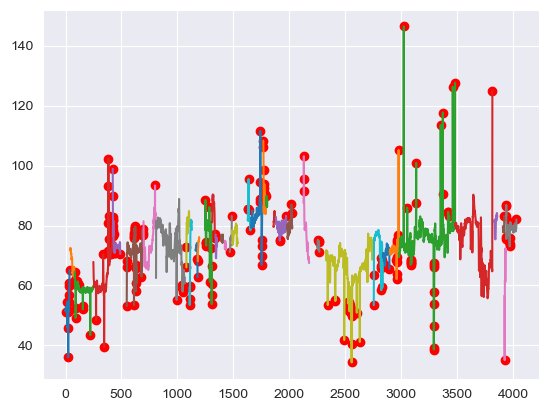

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


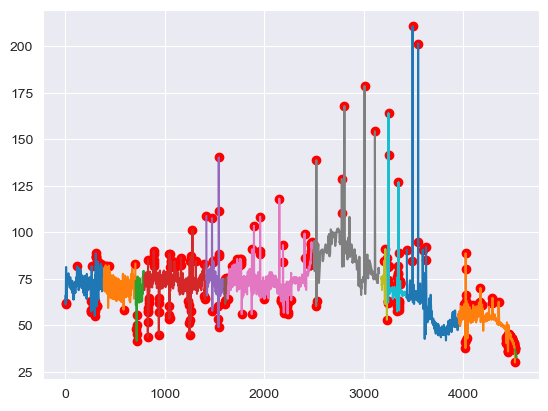

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


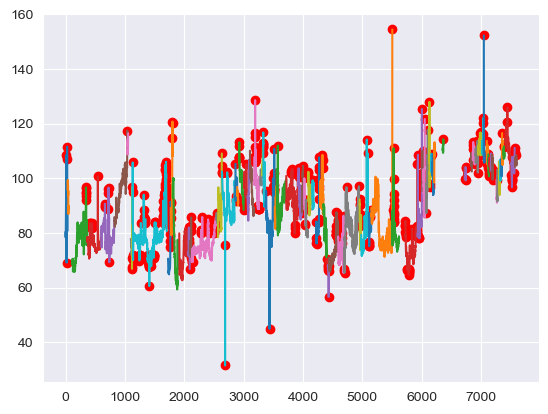

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


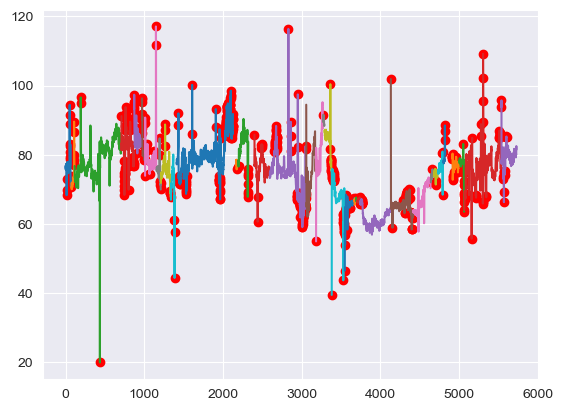

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


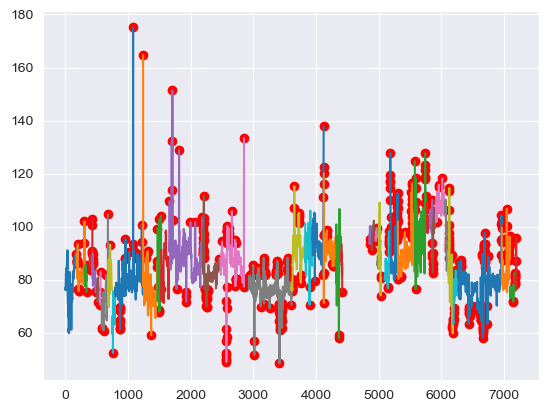

In [48]:
all_outliers = {} 
for patient in patient_sliced_data:
  slices = filter_slices(patient_sliced_data[patient])
  outliers_in_slices = find_outliers_in_slices(slices)
  plot_slices_and_outliers(slices, outliers_in_slices)
  all_outliers[patient] = pd.concat(outliers_in_slices)

---

## Interpolate Outliers

- Plot both original and cleaned data on a single figure for comparison.
- Execute the cleaning process multiple times, which includes:
  - Identifying outliers within the dataset.
  - Detecting intersections between patient data and these outliers.
  - Transforming these intersections into NaNs (Not a Number).
  - Interpolating these NaNs to fill in the missing data.
- Note: The cleaning process is applied across all data columns, not limited to the `ABP` column.
- **Interpolation is conducted on all columns that contain outliers.**
- Interpolation is specifically applied to data points marked as NaNs, ensuring that it **does not occur in sections where data is absent.**

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\

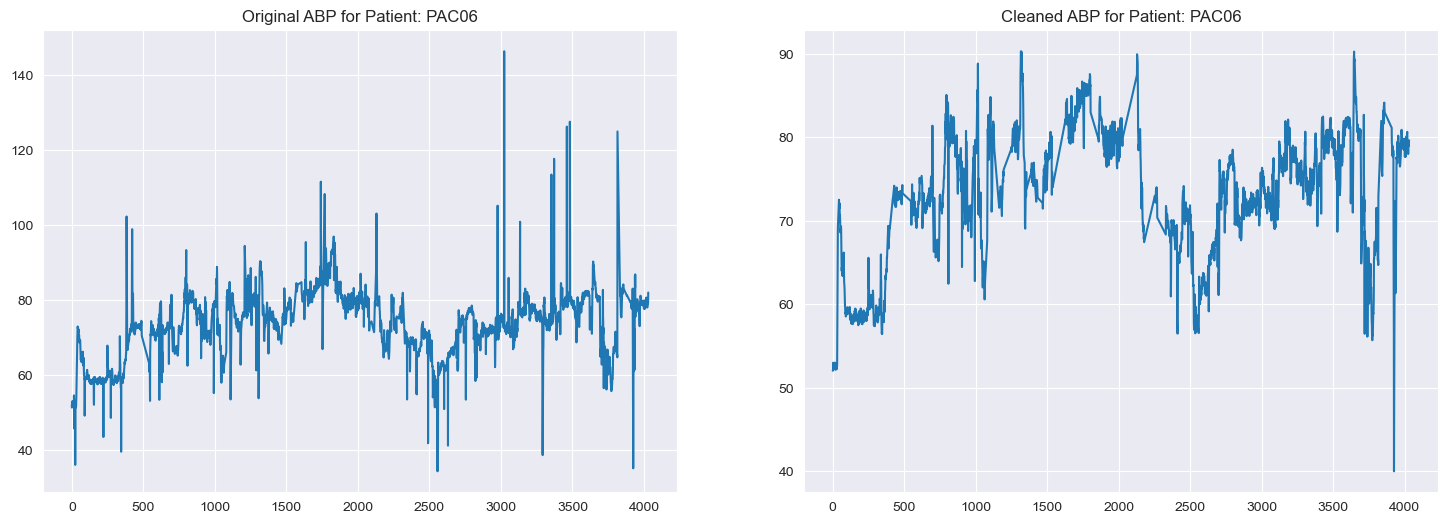

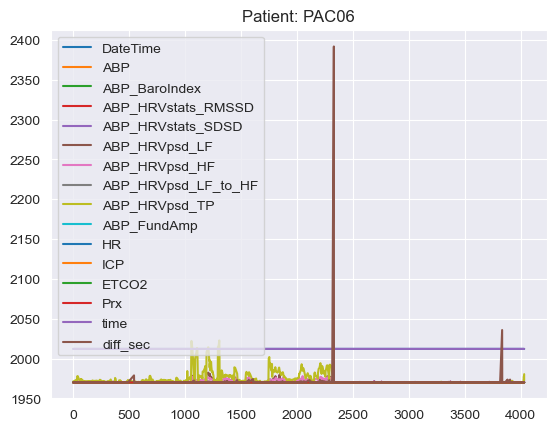

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\

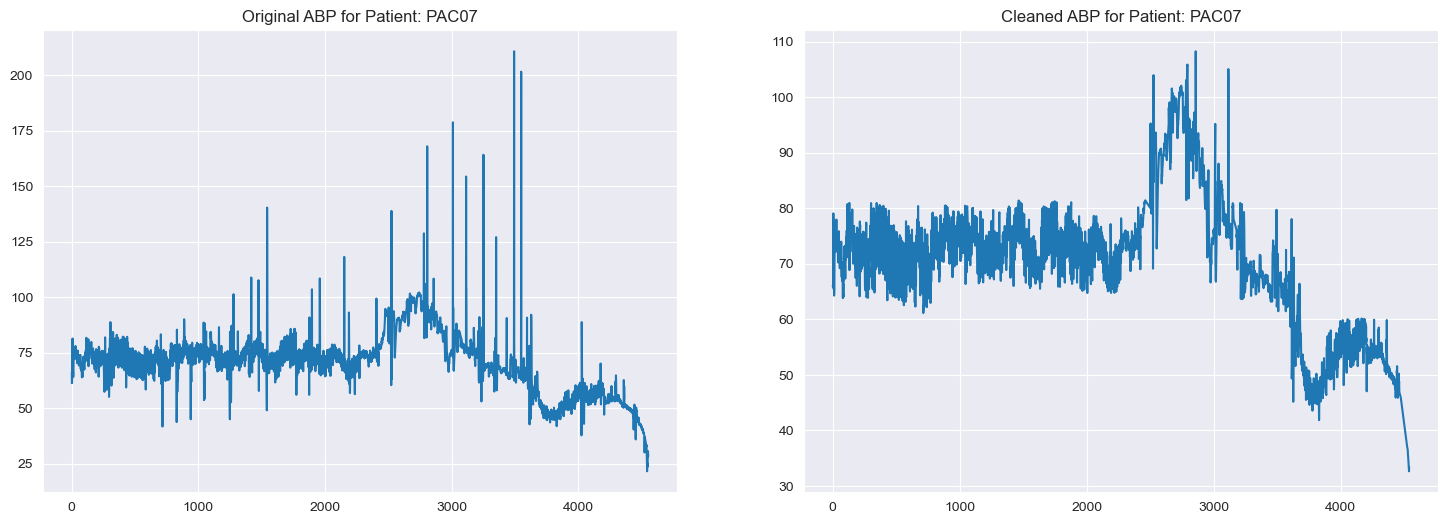

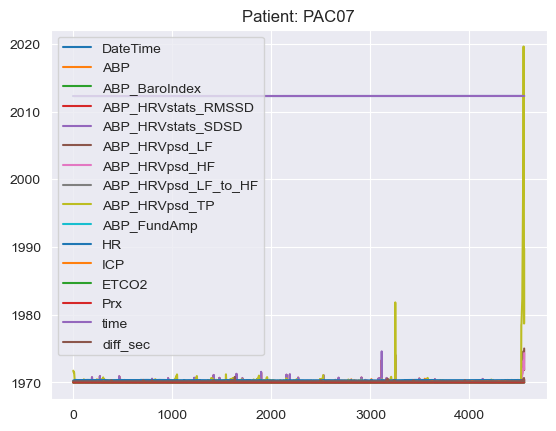

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\

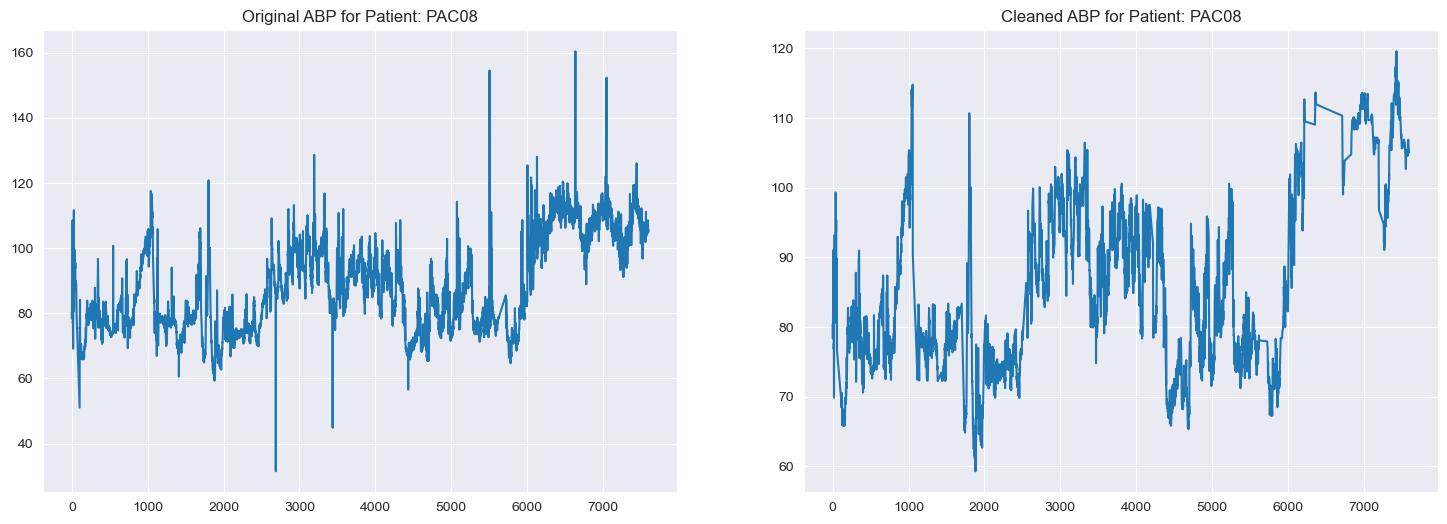

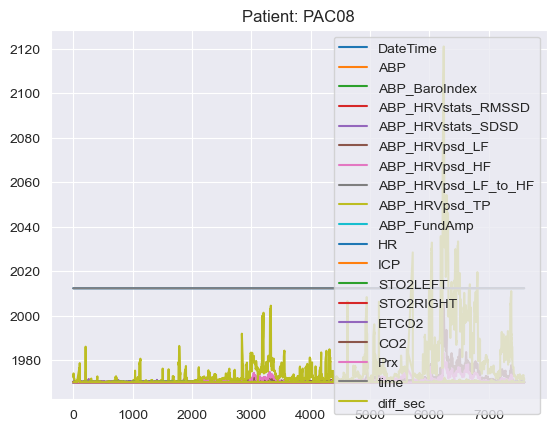

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\

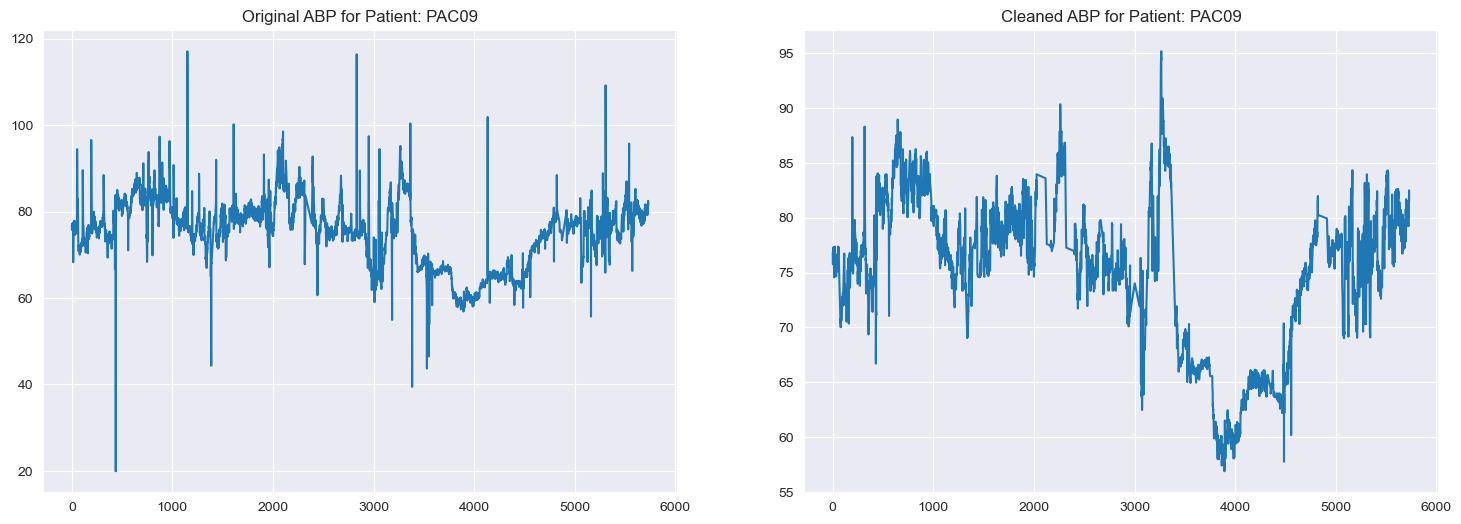

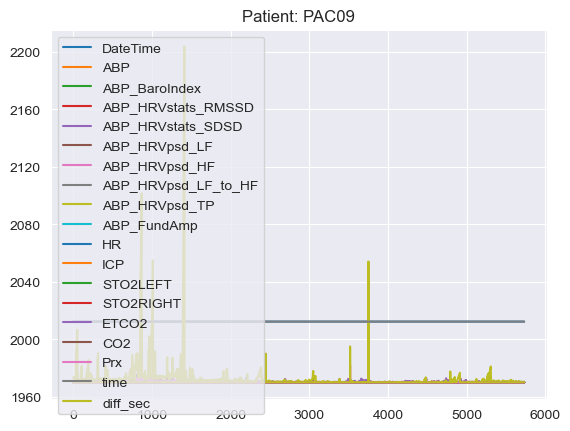

C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
C:\Users\Domin\anaconda3\Lib\site-packages\pandas\core\computation\

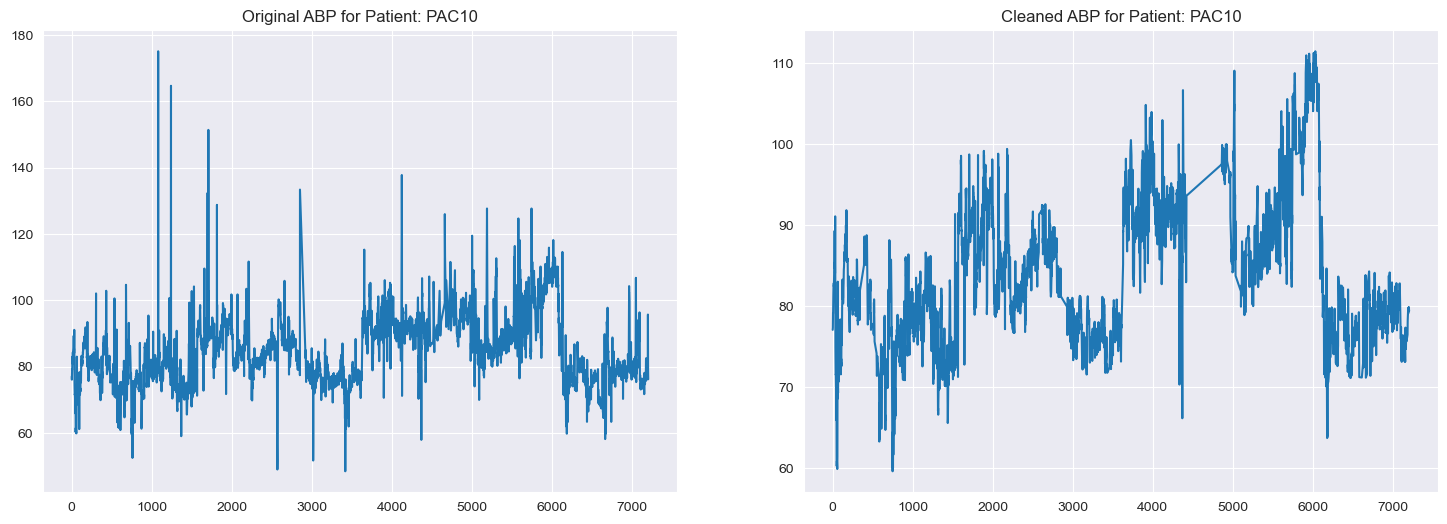

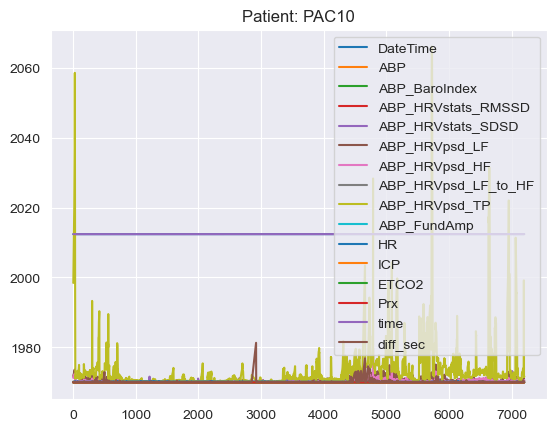

In [49]:
for patient in data_frames.keys():
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    un_cleaned_data = data_frames[patient].copy()
    axs[0].plot(data_frames[patient]['ABP'])
    axs[0].set_title(f"Original ABP for Patient: {patient}")
    un_cleaned_data.plot(title=f"Patient: {patient}")
    
    
    for i in range(20): # Perform cleaning 20 times - It is a good practice to perform cleaning multiple times
        data_frames[patient] = perform_cleaning(data_frames[patient])
        
        
    axs[1].plot(data_frames[patient]['ABP'])
    axs[1].set_title(f"Cleaned ABP for Patient: {patient}")

    plt.show()

--- 

## Save data 

- Ensure the directory `/data_clean` exists; if not, create it.
- Remove the `diff_sec` column from the dataset.
- Append the `_cleaned` prefix to the filename when saving the processed data.

In [50]:
import os

try:
    print("Current working directory:", os.getcwd())
    os.chdir('C:/Users\Domin\PycharmProjects\garch_dominik_cedro_branch')
    if not os.path.exists('data_clean'):
        os.makedirs('data_clean')
    for patient in data_frames.keys():
        data_frames[patient].drop(columns=['diff_sec']).to_csv(f"data_clean/{patient}_cleaned.csv", index=False)
except Exception as e:
    print("An error occurred:", e)

Current working directory: C:\Users\Domin\PycharmProjects\garch_dominik_cedro_branch
